# Gender Pay Gap

Team members: 
* Jordan Farrell 
* Julio Oliveira 
* Ashwath Ramesh 
* Satoshi Taniguchi 
* Junjun Tao 
* William Teodecki 

In [1]:
import pickle
import numpy as np
import pandas as pd

import shap
from fitter import Fitter
import statsmodels.api as sm
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

/home/julio/.local/share/virtualenvs/gender-pay-gap-VcKyyecI/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
columns = [
    'sex', 'age', 'annhrs', 'annlabinc', 'white', 'black', 'hisp', 'degree',
    'yrsexp', 'yrsftexp', 'yrsptexp', 'hrwage', 'northeast', 'northcentral',
    'south', 'west', 'manager', 'business', 'financialop', 'computer',
    'architect', 'scientist', 'socialworker', 'postseceduc', 'legaleduc',
    'artist', 'lawyerphysician', 'healthcare', 'healthsupport', 'protective',
    'foodcare', 'building', 'sales', 'officeadmin', 'constructextractinstall',
    'production', 'transport','farminc', 'labincbus'
]

psid = pd.read_csv('../data/external/PanelStudyIncomeDynamics.csv',
                   usecols=columns)



In [3]:
psid.head()

,sex,farminc,age,annhrs,annlabinc,white,black,hisp,degree,labincbus,...,healthcare,healthsupport,protective,foodcare,building,sales,officeadmin,constructextractinstall,production,transport
0,1,0.0,34,1600,10000.0,1,0,0,1.0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,0.0,32,520,9095.0,0,1,0,0.0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,0.0,64,2550,45200.0,0,1,0,0.0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,0.0,50,3072,25000.0,1,0,0,0.0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,0.0,26,2100,24500.0,1,0,0,0.0,0,...,0,0,0,0,0,0,0,0,1,0


### Column Encoding

In [4]:
def get_category(row, columns):
    for col in columns:
        if row[col] == 1:
            return col


race_cols = ['white', 'black', 'hisp']
region_cols = ['northeast', 'northcentral', 'south', 'west']
job_cols = [
    'manager', 'business', 'financialop', 'computer', 'architect', 'scientist',
    'socialworker', 'postseceduc', 'legaleduc', 'artist', 'lawyerphysician',
    'healthcare', 'healthsupport', 'protective', 'foodcare', 'building',
    'sales', 'officeadmin', 'constructextractinstall', 'production',
    'transport'
]

psid['race'] = psid.apply(lambda x: get_category(x, race_cols), axis=1)
psid.drop(race_cols, axis=1, inplace=True)

psid['region'] = psid.apply(lambda x: get_category(x, region_cols), axis=1)
psid.drop(region_cols, axis=1, inplace=True)

psid['job'] = psid.apply(lambda x: get_category(x, job_cols), axis=1)
psid.drop(job_cols, axis=1, inplace=True)

psid['sex'] = psid.apply(lambda x: 'male' if x['sex'] == 1 else 'female',
                         axis=1)

degree_map = {0: 'no_college', 1: 'bachelors', 2: 'advanced_degree'}
psid['degree'] = psid.degree.map(degree_map)

In [5]:
psid.shape

(33398, 14)

In [6]:
psid.head()

,sex,farminc,age,annhrs,annlabinc,degree,labincbus,yrsexp,yrsftexp,yrsptexp,hrwage,race,region,job
0,male,0.0,34,1600,10000.0,bachelors,0,12.0,12.0,0.0,6.250000,white,northeast,sales
1,male,0.0,32,520,9095.0,no_college,0,14.0,11.0,3.0,17.490385,black,northcentral,production
2,male,0.0,64,2550,45200.0,no_college,0,39.0,38.0,1.0,17.725491,black,northeast,production
3,male,0.0,50,3072,25000.0,no_college,0,30.0,30.0,0.0,8.138021,white,northcentral,transport
4,male,0.0,26,2100,24500.0,no_college,0,8.0,8.0,0.0,11.666667,white,south,production


### Income Columns

In [7]:
income_cols = ['farminc','annlabinc','labincbus', 'annhrs','hrwage']
psid[income_cols].describe()

,farminc,annlabinc,labincbus,annhrs,hrwage
count,33398.000000,3.339800e+04,33398.000000,33398.000000,33398.000000
mean,104.879544,3.708689e+04,168.051859,1990.103449,18.418722
std,2662.001098,4.156487e+04,2257.977695,623.592732,19.462814
min,-5000.000000,3.000000e+01,0.000000,10.000000,0.891473
25%,0.000000,1.600000e+04,0.000000,1767.000000,8.823529
50%,0.000000,2.900000e+04,0.000000,2000.000000,14.423077
75%,0.000000,4.600000e+04,0.000000,2277.000000,22.373541
max,200000.000000,1.500000e+06,99999.000000,5840.000000,1000.000000


Looking into anomalous values in income we were able to find the farm incomes can be negative.

In [8]:
psid[psid['farminc'] != 0][income_cols].describe()

,farminc,annlabinc,labincbus,annhrs,hrwage
count,120.000000,120.000000,120.000000,120.000000,120.000000
mean,29189.725000,24491.858333,114.133333,1860.741667,12.721140
std,33654.453819,18135.461596,933.531183,668.718635,7.682096
min,-5000.000000,400.000000,0.000000,129.000000,2.334267
25%,7000.000000,10748.750000,0.000000,1470.000000,7.179206
50%,20000.000000,21000.000000,0.000000,2000.000000,10.971956
75%,40250.000000,33325.000000,0.000000,2173.250000,16.811773
max,200000.000000,101400.000000,10000.000000,3491.000000,41.666668


100% of the dataset has annual labor income greater than 0.

In [9]:
psid[psid.annlabinc > 0].shape[0] / psid.shape[0] 

1.0

There is no considerable amount of missing values for the main attributes.

In [10]:
psid.isnull().sum()

sex            0
farminc        0
age            0
annhrs         0
annlabinc      0
degree        40
labincbus      0
yrsexp         0
yrsftexp       0
yrsptexp       0
hrwage         0
race         417
region         3
job          189
dtype: int64

### Classes distribution

See dataset description for more details: https://github.com/jcalvesoliveira/gender-pay-gap/blob/master/docs/datasets/PanelStudyIncomeDynamics.names

#### Distribution of labor income

,sumsquare_error,aic,bic,kl_div
chi2,1.402789e-11,8022.927868,-1.182466e+06,inf
expon,8.829477e-11,6155.790778,-1.121036e+06,inf
norm,2.396454e-10,42587.165871,-1.087689e+06,inf
lognorm,7.046555e-10,3425.914448,-1.051657e+06,inf


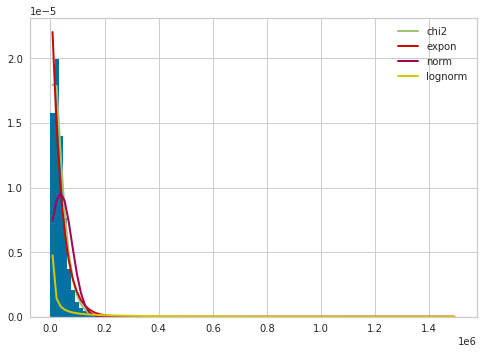

In [11]:
f = Fitter(psid.annlabinc,
           distributions=['lognorm',
                          "norm", "expon","chi2"])
f.fit()
f.summary()

The labor income distribution is skewed to the right, meaning that a small amount of people will make a lot of money. In order to focus our analysis in the overall population we filter out the 10% highest incomes by selecting the 90th percentile.

In [12]:
q_99 = psid.annlabinc.quantile(0.99)
q_99

171000.0

### What categorical features may have an effect on income?

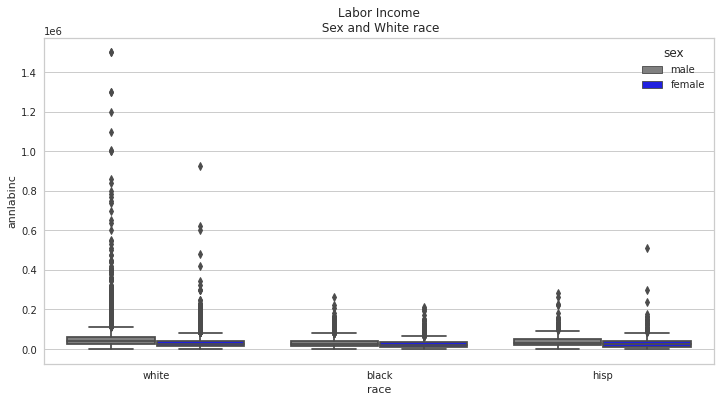

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set(title="Labor Income\n Sex and White race")
ax = sns.boxplot(x="race", y="annlabinc", hue="sex",
                 data=psid, 
                 dodge=True, ax = ax, palette=['gray','blue'])

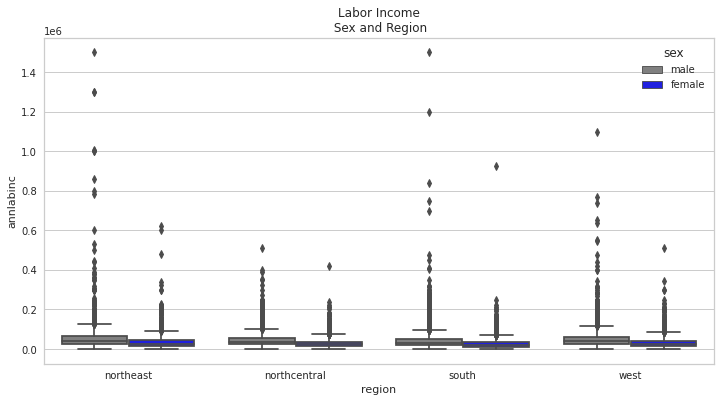

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set(title="Labor Income\n Sex and Region")
ax = sns.boxplot(x="region", y="annlabinc", hue="sex",
                 data=psid, 
                 dodge=True, ax = ax, palette=['gray','blue'])

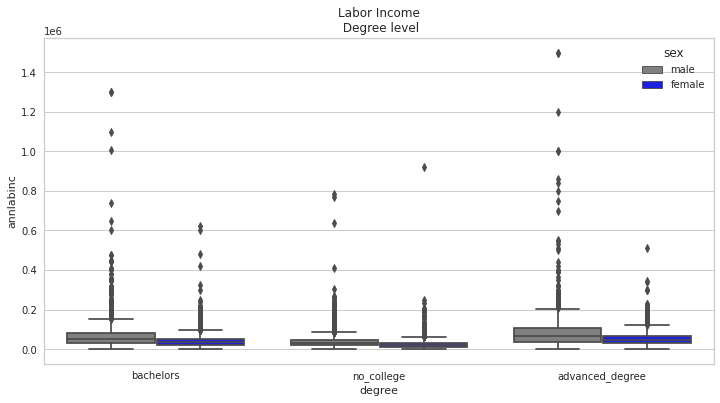

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set(title="Labor Income\n Degree level")
ax = sns.boxplot(x="degree", y="annlabinc", hue="sex",
                 data=psid, 
                 dodge=True, ax = ax, palette=['gray','blue'])

## Data Cleaning

In [16]:
psid = psid[psid.annlabinc < q_99]
psid.degree.fillna('no_college', inplace=True)
psid.job.fillna('na', inplace=True)
psid.race.fillna('na', inplace=True)
psid = psid[psid['region'].notna()]

In [17]:
psid.to_csv('../data/processed/psid.csv')

### What categorical features may have an effect on income?

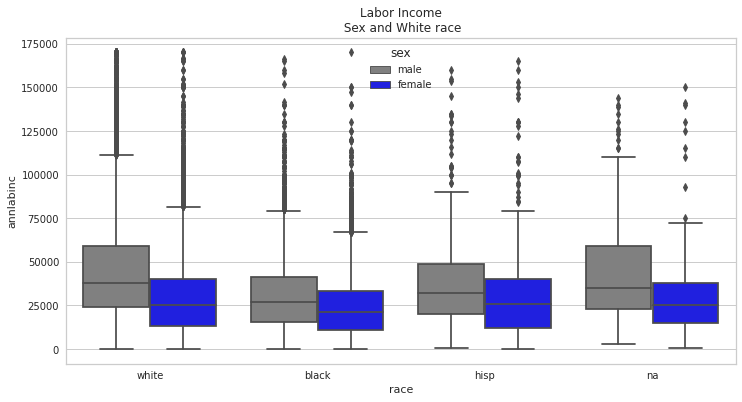

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set(title="Labor Income\n Sex and White race")
ax = sns.boxplot(x="race", y="annlabinc", hue="sex",
                 data=psid, 
                 dodge=True, ax = ax, palette=['gray','blue'])

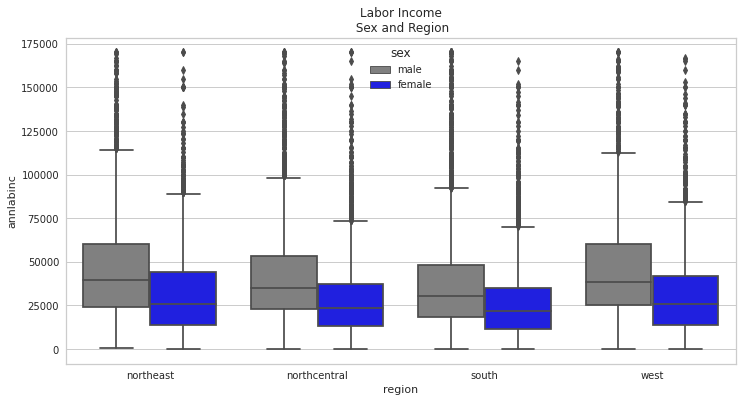

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set(title="Labor Income\n Sex and Region")
ax = sns.boxplot(x="region", y="annlabinc", hue="sex",
                 data=psid, 
                 dodge=True, ax = ax, palette=['gray','blue'])

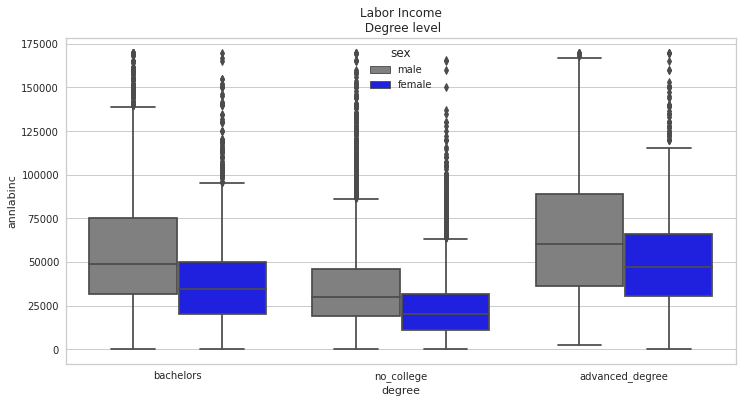

In [20]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set(title="Labor Income\n Degree level")
ax = sns.boxplot(x="degree", y="annlabinc", hue="sex",
                 data=psid, 
                 dodge=True, ax = ax, palette=['gray','blue'])

Looking into the plot below, we can observe that different from what we would expect we could not identify a clear relationship between age and years of experience with labor income.

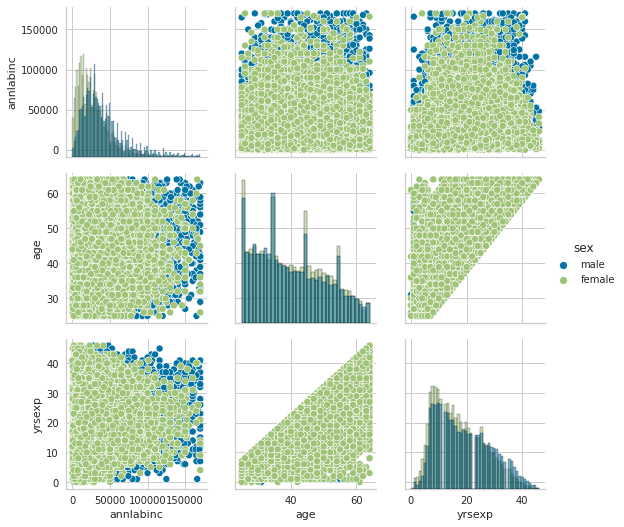

In [21]:
g = sns.PairGrid(psid[['annlabinc','age','sex','yrsexp']], hue="sex")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

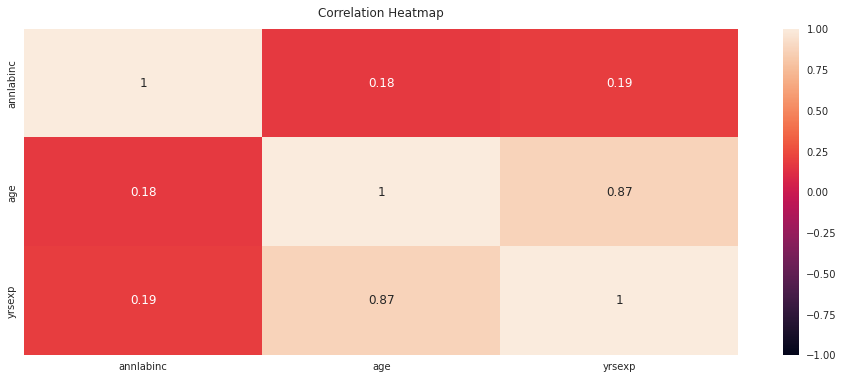

In [22]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(psid[['annlabinc','age','yrsexp']].corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

# Data Transformation

In [23]:
psid.drop(['annlabinc','yrsftexp', 'yrsptexp','farminc','labincbus'], axis=1, inplace=True)

In [24]:
psid.age.describe()

count    33060.000000
mean        40.411827
std         10.397327
min         25.000000
25%         31.000000
50%         39.000000
75%         49.000000
max         64.000000
Name: age, dtype: float64

In [25]:
psid.annhrs.describe()

count    33060.000000
mean      1985.416243
std        623.083807
min         10.000000
25%       1764.000000
50%       2000.000000
75%       2268.000000
max       5840.000000
Name: annhrs, dtype: float64

In [26]:
psid.yrsexp.describe()

count    33060.000000
mean        18.061162
std          9.383590
min          0.000000
25%         10.000000
50%         17.000000
75%         25.000000
max         46.000000
Name: yrsexp, dtype: float64

In [27]:
psid['annhrs'] = pd.cut(psid['annhrs'], bins=[0,1764, 2000, 2268,6000],labels=['0-1764','1764-2000','2000-2268','2268-6000'])
psid['age'] = pd.cut(psid['age'], bins=[0,31, 39, 49,64],labels=['0-31','31-39','39-49','49-64'])
psid['yrsexp'] = pd.cut(psid['yrsexp'], bins=[0,10, 17, 25,46], labels=['0-10','10-17','17-25','25-46'])

In [28]:
X = psid.drop(['hrwage'], axis=1)
y = psid.hrwage.copy()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}, proportion: {X_train.shape[0] / (X_train.shape[0] + X_test.shape[0])}")

X_train shape: (26448, 8), X_test shape: (6612, 8), proportion: 0.8


In [29]:
cat_cols = ['sex','degree','race', 'job', 'region','age','annhrs','yrsexp']

In [30]:
encoding_transf = ColumnTransformer(remainder='passthrough',
                       transformers=[('ohe', OneHotEncoder(drop='first', sparse=False), cat_cols)],
                       verbose_feature_names_out=True)
norm_transf = ColumnTransformer(remainder='passthrough',
                       transformers=[('norm', MinMaxScaler())])

pipeline = Pipeline([
    ('encoding',encoding_transf),
    ('normalization', MinMaxScaler())
])

In [31]:
X_train = pipeline.fit_transform(X_train,y_train)
X_test = pipeline.transform(X_test)
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [32]:
feature_names=list(pipeline.get_feature_names_out())

In [33]:

predicted = lr.predict(X_test)
predicted

array([ 6.86714946,  9.76743895,  9.52532006, ...,  8.36140376,
       31.97124922, 16.48811779])

In [34]:
print(f"Wage mean:{y_test.mean():.2f}, std:{y_test.std():.2f}, range:{y_test.min():.2f}-{y_test.max():.2f}")
print(f"R2 score: {r2_score(y_test, predicted)}")
print(f"MSE: {mean_squared_error(y_test, predicted)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, predicted))}")

Wage mean:17.18, std:12.40, range:0.89-166.56
R2 score: 0.2645586985709846
MSE: 113.07469607048867
RMSE: 10.633658639926743


In [35]:
X2 = sm.add_constant(X_train)
ols = sm.OLS(y_train, X2).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                 hrwage   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     174.3
Date:                Thu, 21 Apr 2022   Prob (F-statistic):               0.00
Time:                        15:15:09   Log-Likelihood:            -1.0523e+05
No. Observations:               26448   AIC:                         2.105e+05
Df Residuals:                   26407   BIC:                         2.109e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.8702      0.701     36.892      0.0

## Accesing model

In [36]:
shap.initjs()

In [50]:
X_train_df = pd.DataFrame(X_train, columns=pipeline.get_feature_names_out())
X_test_df = pd.DataFrame(X_test, columns=pipeline.get_feature_names_out())

In [77]:
masker = shap.maskers.Independent(data = X_train_df)
explainer = shap.LinearExplainer(lr, masker,feature_perturbation="correlation_dependent")
shap_values = explainer.shap_values(X_test_df)

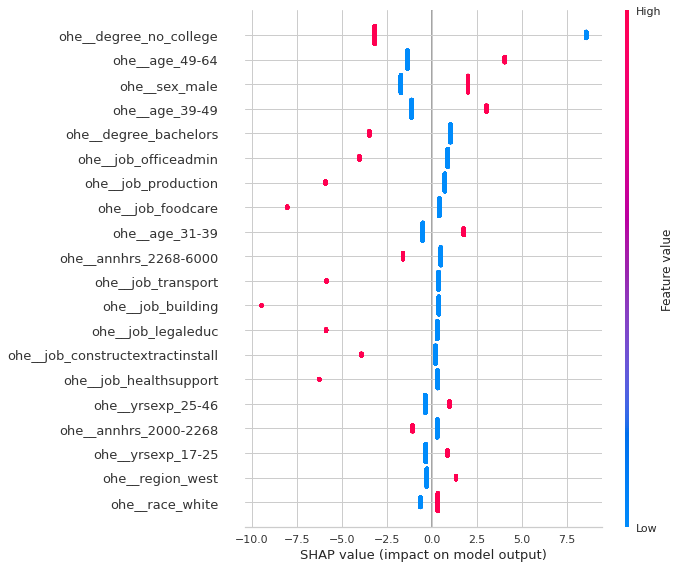

In [78]:
shap.summary_plot(shap_values, X_test_df)

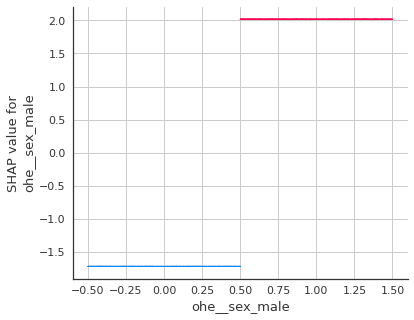

In [83]:
shap.dependence_plot("ohe__sex_male", shap_values, X_test_df, x_jitter=1, dot_size=1, interaction_index="ohe__sex_male")

In [70]:
no_college = X_test_df["ohe__degree_no_college"] == 1
white = X_test_df["ohe__race_white"] == 1
college = X_test_df["ohe__degree_bachelors"] == 1
manager = X_test_df["ohe__job_manager"] == 1
west = X_test_df["ohe__region_west"] == 1
low_experience = X_test_df["ohe__yrsexp_10-17"] == 1
high_experience = X_test_df["ohe__yrsexp_25-46"] == 1

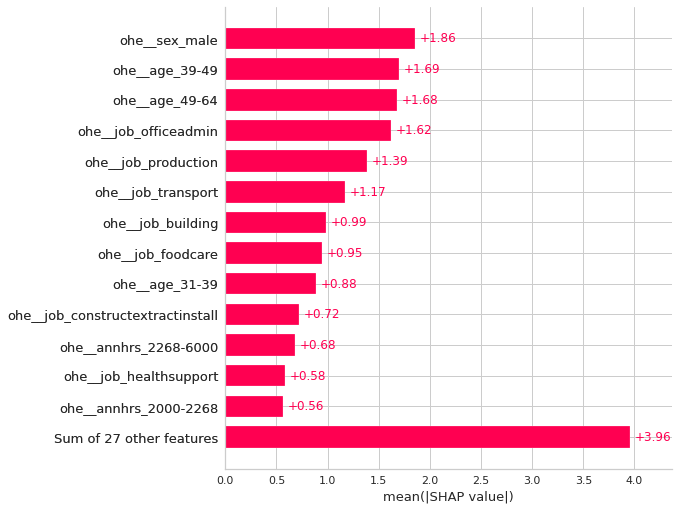

In [85]:
filter_ = no_college
masker = shap.maskers.Independent(data = X_test_df[filter_])
explainer = shap.LinearExplainer(lr, masker,feature_perturbation="correlation_dependent")
shap_values = explainer(X_test_df[filter_])
shap.plots.bar(shap_values, max_display=14)

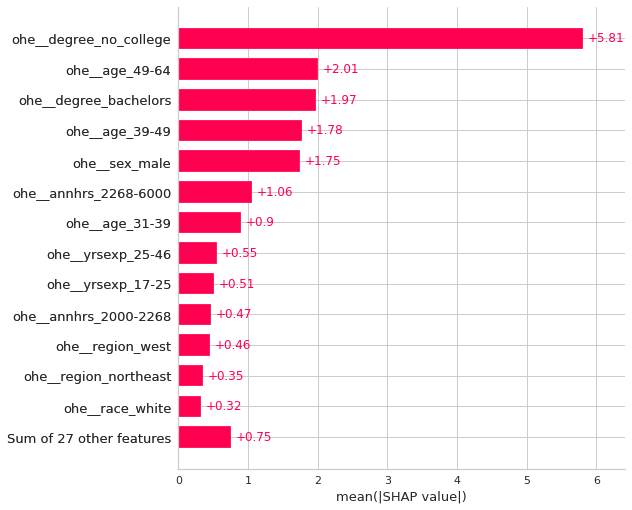

In [86]:
filter_ = manager
masker = shap.maskers.Independent(data = X_test_df[filter_])
explainer = shap.LinearExplainer(lr, masker,feature_perturbation="correlation_dependent")
shap_values = explainer(X_test_df[filter_])
shap.plots.bar(shap_values, max_display=14)